# Analysis of James Bond franchise movies

This is a small notebook where I am doing some small analysis on the
movies from the James Bond franchise. I am using ratings data from the
<a href="https://grouplens.org/datasets/movielens/" target="_blank">
    MovieLens
</a>
data set recommended for education and development, hand-copied data from
<a href="https://www.the-numbers.com/movies/franchises" target="_blank">
    The Numbers Movie Franchises
</a>
for the budget, release dates, and total earnings. I am also using the
<a href="https://datasets.imdbws.com/" target="_blank">
    IMDb ratings data set
</a>
for comparison to the MovieLens data set.

This was actually prompted by trying to analyze different franchises and I
saw that horror movie franchises are actually really profitable and it made
me curious as to what other movie franchises have. I then saw that the
James Bond franshise had a lot of the early movies be quite profitable
(high return on investment) and I started to dig a bit deeper and it turned
into this notebook where I try to find a reason why with the data that I
have available to me.

I hope you enjoy going through this notebook as much as it was for me to
create it all and learn a lot more about how pandas can be used in data
manipulation and how dataframes are joined together like in SQL.

## Imports and function definitions

In [1]:
from matplotlib.lines import Line2D
import ipywidgets as widgets
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [2]:
def get_roi(data):
    '''
    Get the return on investment for the data set

    Args:
        data (pandas.DataFrame): Data frame with the budget
            and earnings data.

    Returns:
        df (pandas.DataFrame): Data frame copied from the
            original data with two new columns 'profit' and
            'roi'.
    '''
    df = data.copy()
    df['profit'] = df['earningsTotal'] - df['budgetTotal']
    df['roi'] = df['profit'] / df['budgetTotal'] * 100
    return df

def align_y_axis(ax1, ax2):
    '''
    Align two matplolib.axes.Axes objects such that the
    0's on the y-axis of the plots are aligned correctly.
    This function works such that the plots are zoomed out
    by a ratio that will force the 0's to align.

    Args:
        ax1 (matplotlib.axes.Axes): Axes object from the
            plot.
        ax2 (maptlotlib.axes.Axes): Axes object from the
            plot. Typically a twinx object.
    '''
    axes = (ax1, ax2)
    extrema = [ax.get_ylim() for ax in axes]
    tops = [extr[1] / (extr[1] - extr[0]) for extr in extrema]
    if tops[0] > tops[1]:
        axes, extrema, tops = [list(reversed(l)) for l in (axes, extrema, tops)]
    tot_span = tops[1] + 1 - tops[0]
    b_new_t = extrema[0][0] + tot_span * (extrema[0][1] - extrema[0][0])
    t_new_b = extrema[1][1] - tot_span * (extrema[1][1] - extrema[1][0])
    axes[0].set_ylim(extrema[0][0], b_new_t)
    axes[1].set_ylim(t_new_b, extrema[1][1])

def get_name(df, column):
    ''' Just a small helper function '''
    name = df[column].unique()
    if name.shape[0] > 1:
        raise ValueError("Failed determining name for column {}".format(column))
    else:
        name = name[0]
    return name

def get_actorName(actorId):
    actors = data_df['franchise_tags'][['actor', 'actorId']].drop_duplicates() \
                .set_index('actorId').T.to_dict(orient='list')
    try:
        actorName = actors[actorId][0]
    except KeyError:
        raise KeyError('There is no actor with an actorId value of {}'.format(actorId))
    return actorName

def get_movieName(movieId):
    movies = jb_ratings[['title', 'movieId']].drop_duplicates() \
                .set_index('movieId').T.to_dict(orient='list')
    try:
        movieName = movies[movieId][0]
    except KeyError:
        raise KeyError('There is no movie with the movieId value of {}'.format(movieId))
    return movieName

def get_movieDate(movieId):
    movies = jb_ratings[['date', 'movieId']].drop_duplicates() \
                .set_index('movieId').T.to_dict(orient='list')
    try:
        movieDate = movies[movieId][0]
    except KeyError:
        raise KeyError('There is no movie with the movieId value of {}'.format(movieId))
    return movieDate

def get_actorId(actorName):
    actors = data_df['franchise_tags'][['actor', 'actorId']].drop_duplicates() \
                .set_index('actor').T.to_dict(orient='list')
    try:
        actorId = actors[actorName][0]
    except KeyError:
        raise KeyError('There is no actor with the name {}'.format(actorName))
    return actorId
    
def generate_ratings(actorName, df, fstart):
    '''
    Generate a plot figure for the ratings of the specific
    actor given as an input. It is hard-coded that it will
    get the average rating over a yearly period.

    Args:
        actorName (str): Name of the actor for which you
            want to generate the plot.

    Returns:
        fig (matplotlib.pyplot.figure): Matplotlib figure
            object with the plotted data.
    '''
    actorId = get_actorId(actorName)
    label = '{:s} ({:d})'
    data = df.groupby('actorId').get_group(actorId)
    fig = plt.figure(fstart+actorId, figsize=(10,5), dpi=75)
    ax = fig.add_subplot(111)
    for movieId, sub_data in data.groupby('movieId'):
        movieName = get_name(sub_data, 'title')
        releaseDate = get_name(sub_data, 'date')
        all_time_avg = sub_data['rating'].mean()
        tmp = sub_data.groupby(pd.Grouper(key='reviewDate', freq='1Y'))['rating'].mean()
        ax.plot(tmp.index, tmp, label=label.format(movieName, releaseDate.year))
    ax.set_title(actorName, fontsize=18)
    ax.legend(bbox_to_anchor=(1.01,1), loc='upper left',
              fontsize=14)
    fig.tight_layout()
    return fig

def generate_hist(actorName, df, fstart):
    '''
    Generate a histogram plot of the ratings for each movie
    of the specific actor given as an input. Will display
    the mean, standard deviation, and total votes in the plot
    title. We also add the probability density with the
    parameters as calculated by the matplotlib histogram
    method. The plot will be displayed as the probability
    density instead of the total number of votes for the bin.

    Args:
        actorName (str): Name of the actor for which you
            want to generate the plot.

    Returns:
        fig (matplotlib.pyplot.figure): Matplotlib figure
            object with the plotted data.
    '''
    actorId = get_actorId(actorName)
    data = df.groupby('actorId').get_group(actorId)
    label = '{name:s} ({date:d})\navg: {avg:.2f} | std: {std:.2f}' \
            +'\nmedian: {med:.2f} | votes: {nvotes:d}'
    nrows = int(np.ceil(data['movieId'].unique().shape[0]/2))
    fig = plt.figure(fstart+actorId, figsize=(10,nrows*4), dpi=75)
    for idx, (movieId, sub_data) in enumerate(data.groupby('movieId')):
        ax = fig.add_subplot(nrows,2,idx+1)
        movieName = get_name(sub_data, 'title')
        releaseDate = get_name(sub_data, 'date')
        all_time_avg = sub_data['rating'].mean()
        all_time_median = sub_data['rating'].median()
        nvotes = sub_data.shape[0]
        hist_data = np.histogram(sub_data['rating'], bins=10, range=[0,5])
        n, bins, patches = ax.hist(sub_data['rating'], bins=10, range=[0,5],
                                   width=0.4, align='mid', density=True)
        # add a 'best fit' line
        sigma = sub_data['rating'].std()
        mu = all_time_avg
        y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
             np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
        ax.plot(bins, y, '--')
        ax.axvline(all_time_avg, color='k', linestyle='-')
        ax.axvline(all_time_median, color='k', linestyle=(0, (5, 6)))
        kwargs = dict(name=movieName, date=releaseDate.year, avg=all_time_avg,
                      med=all_time_median, std=sigma, nvotes=nvotes)
        ax.set_title(label.format(**kwargs), fontsize=18)
    fig.suptitle('Histogram of ratings with {} as lead actor'.format(actorName), fontsize=24)
    fig.tight_layout(rect=(0,0,1,0.99))
    return fig

def generate_lineplot(actorName, df, fstart):
    # print(df)
    actorId = get_actorId(actorName)
    data = df.groupby('actorId').get_group(actorId)
    nrows = int(np.ceil(data['movieId'].unique().shape[0]/2))
    fig = plt.figure(fstart+actorId, figsize=(10,nrows*4), dpi=75)
    for idx, (movieId, sub_data) in enumerate(data.groupby('movieId')):
        ax = fig.add_subplot(nrows,2,idx+1)
        ax1 = ax.twinx()
        orig = sub_data.groupby('type').get_group('original')
        sub_data.drop(orig.index, inplace=True)
        movieName = get_movieName(movieId)
        movieDate = get_movieDate(movieId)
        xticks = [x+' ('+str(y)+')' for x, y in zip(sub_data['type'], sub_data['count'])]
        ax.plot(xticks, sub_data['average'], label='Average', color='tab:blue',
                marker='o')
        ax.plot(xticks, sub_data['median'], label='Median', color='tab:orange',
                marker='o')
        ax1.plot(xticks, sub_data['std'], color='tab:green', label='STD',
                marker='o')
        ax.axhline(orig['average'].values[0], color='tab:blue', linestyle=(0, (5, 6)))
        ax.axhline(orig['median'].values[0], color='tab:orange', linestyle=(0, (5, 6)))
        ax1.axhline(orig['std'].values[0], color='tab:green', linestyle=(0, (5, 6)))
        h1, l1 = ax.get_legend_handles_labels()
        h2, l2 = ax1.get_legend_handles_labels()
        custom = [Line2D([0], [0], color='k', linestyle='--')]
        handles = h1+h2+custom
        labels = l1+l2+['Original']
        ax.legend(handles, labels, bbox_to_anchor=(1.15,1), loc='upper left')
        ax.set_ylabel('Rating / out of 5')
        ax1.set_ylabel('STD')
        ax.set_title('{:s} ({:d})'.format(movieName, movieDate.year))
        for label in ax.get_xticklabels():
            label.set_rotation(40)
            label.set_horizontalalignment('right')
    fig.tight_layout()
    return fig

def gen_tab_object(func, df, fstart):
    names = ['Daniel Craig', 'Pierce Brosnan', 'Roger Moore', 'Sean Connery',
         'Timothy Dalton', 'George Lazenby', 'David Niven']
    out1 = widgets.Output()
    out2 = widgets.Output()
    out3 = widgets.Output()
    out4 = widgets.Output()
    out5 = widgets.Output()
    out6 = widgets.Output()
    out7 = widgets.Output()
    with out1: plt.show(func('Daniel Craig', df=df, fstart=fstart))
    with out2: plt.show(func('Pierce Brosnan', df=df, fstart=fstart))
    with out3: plt.show(func('Roger Moore', df=df, fstart=fstart))
    with out4: plt.show(func('Sean Connery', df=df, fstart=fstart))
    with out5: plt.show(func('Timothy Dalton', df=df, fstart=fstart))
    with out6: plt.show(func('George Lazenby', df=df, fstart=fstart))
    with out7: plt.show(func('David Niven', df=df, fstart=fstart))
    tabs = widgets.Tab(children=[out1, out2, out3, out4, out5, out6, out7])
    [tabs.set_title(i, name) for i, name in enumerate(names)]
    return tabs

### Parse the data

In [3]:
dfs = {}
dirs = dict(large='ml-latest')
files = ['franchise_movies.csv', 'franchise_tags.csv', 'links.csv', 'ratings.csv']
for key, parent in dirs.items():
    dfs[key] = {}
    for fn in os.listdir(parent):
        if not fn.endswith('.csv'): continue
        if fn not in files: continue
        sub_key = fn.replace('.csv', '')
        dtypes = dict(userId=int, movieId=int,
                      imdbId=str, tmdbId=str)
        filename = os.path.join(parent, fn)
        dfs[key][sub_key] = pd.read_csv(filename, dtype=dtypes)
all_data = dfs

In [4]:
main = 'imdb-data'
parent = 'title-ratings'
dtypes = dict(tconst=str, numVotes=int)
fn = os.path.join(main, parent, 'data.tsv')
df = pd.read_csv(fn, sep='\t', dtype=dtypes)
df['tconst'] = df['tconst'].apply(lambda x: x[2:])
df = df.merge(all_data['large']['links'], left_on='tconst', right_on='imdbId', how='right')
all_data['imdb-ratings'] = df

### Convert timestamps to human readable dates

In [5]:
data_df = all_data['large'].copy()
data_df['franchise_movies']['date'] = pd.to_datetime(data_df['franchise_movies']['releaseDate'], unit='s')

## Analysis of return on investment

In [6]:
indv_roi = get_roi(data_df['franchise_movies'])

In [7]:
jb_movies = indv_roi.groupby('seriesId').get_group(10).copy()
jb_movies['date'] = pd.to_datetime(jb_movies['releaseDate'], unit='s')
jb_movies.sort_values(by=['roi'], ascending=False)[['title', 'date', 'budgetTotal', 'profit', 'roi']].reset_index(drop=True)

title       date  budgetTotal     profit  \
0                            Dr. No 1963-05-08      1000000   58567035   
1                        Goldfinger 1964-12-22      3000000  121900000   
2             From Russia with Love 1964-04-08      2000000   76900000   
3                  Live and Let Die 1973-06-27      7000000  154800000   
4              Diamonds Are Forever 1971-12-17      7200000  108799985   
5                       Thunderball 1965-12-29      9000000  132200000   
6       The Man with the Golden Gun 1974-12-20      7000000   90600000   
7              The Spy Who Loved Me 1977-07-13     14000000  171400000   
8               You Only Live Twice 1967-06-13      9500000  102100000   
9   On Her Majesty's Secret Service 1969-12-18      8000000   74000000   
10               For Your Eyes Only 1981-06-26     28000000  167300000   
11                        Octopussy 1983-06-10     27500000  160000000   
12                        Moonraker 1979-06-29     31000000  179300000   
13                        Goldeneye 1995-11-17     60000000  296429933   
14                    Casino Royale 2006-11-17    102000000  492420216   
15                          Skyfall 2012-11-08    200000000  910526981   
16                 A View to a Kill 1985-05-24     30000000  122627960   
17             The Living Daylights 1987-07-31     40000000  151199996   
18            Never Say Never Again 1983-10-07     36000000  124000000   
19                  Licence to Kill 1989-07-14     42000000  114167015   
20                    Casino Royale 1967-04-28     12000000   29744718   
21              Tomorrow Never Dies 1997-12-19    110000000  229504276   
22                  Die Another Day 2002-11-22    142000000  289942139   
23                   No Time to Die 2021-10-08    250000000  509959662   
24                          Spectre 2015-11-06    300000000  579077344   
25          The World is Not Enough 1999-11-19    135000000  226730660   
26                Quantum of Solace 2008-11-14    230000000  361692078   

            roi  
0   5856.703500  
1   4063.333333  
2   3845.000000  
3   2211.428571  
4   1511.110903  
5   1468.888889  
6   1294.285714  
7   1224.285714  
8   1074.736842  
9    925.000000  
10   597.500000  
11   581.818182  
12   578.387097  
13   494.049888  
14   482.764918  
15   455.263490  
16   408.759867  
17   377.999990  
18   344.444444  
19   271.826226  
20   247.872650  
21   208.640251  
22   204.184605  
23   203.983865  
24   193.025781  
25   167.948637  
26   157.257425

What you can actually see is that a lot of the older James Bond movies actually
have a much higher return on investment that the newer ones with Quantum of
Solace actually performing the worst. Could this stem from how action movies
themselves are more expensive to produce?

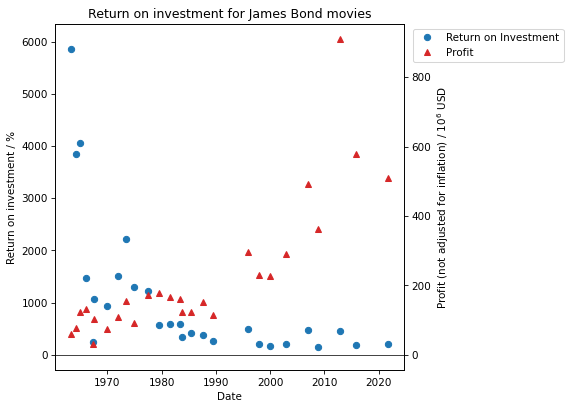

In [8]:
fig = plt.figure(1, figsize=(6,6), dpi=75)
x = np.linspace(jb_movies['releaseDate'].min(), jb_movies['releaseDate'].max(), 100)
ax = fig.add_subplot(111)
ax2 = ax.twinx()
ax.axhline(0, color='k', linewidth=0.7)
ax.plot(jb_movies['date'], jb_movies['roi'], 'o', label='Return on Investment')
ax2.plot(jb_movies['date'], jb_movies['profit']/1e6, '^', color='tab:red', label='Profit')
ax.set_xlabel('Date')
ax.set_ylabel('Return on investment / %')
ax2.set_ylabel('Profit (not adjusted for inflation) / 10$^6$ USD')
ax.set_title('Return on investment for James Bond movies')
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
handles = h1 + h2
labels = l1 + l2
ax.legend(handles, labels, bbox_to_anchor=(1.01,1), loc='upper left')
align_y_axis(ax, ax2)

Here we see a plot of the return on investment for the James Bond series in blue
and the profit in red. We see how the profit (not adjusted for inflation) actually
goes up significantly. So let's maybe take a look at how the ratings for the movies
has changed over time.

## Ratings per lead actor

In [9]:
df1 = jb_movies.copy()
df1.reset_index(drop=True, inplace=True)
tmp = data_df['ratings'].merge(df1[['movieId', 'title', 'releaseDate', 'date', 'roi']], on='movieId')
jb_ratings = tmp.merge(data_df['franchise_tags'][['movieId', 'actor', 'actorId']], on='movieId')
jb_ratings['reviewDate'] = pd.to_datetime(jb_ratings['timestamp'], unit='s')

In [10]:
tabs = gen_tab_object(generate_ratings, jb_ratings, 2)
tabs

Unfortunately, our dataset that we got from MovieLens is incomplete
for all but the James Bond movies starring Daniel Craig and Pierce
Brosnan as they are just too old. Overall, however, there does not
seem to be a consistent trend in the data showing a reason for either
a decrease or increase of return on investment or profit, respectively.

A quick look through Wikipedia (
[this](https://en.wikipedia.org/wiki/Portrayal_of_James_Bond_in_film#Films)
in particular) actually shows a steady increase in the salary of the
lead actors and if we factor the increased use of VFX and stunts it
might be enough to really show how the movies don't have as big of
a return on investment, and with an increased use of VFX and the
advancement in the realism of VFX could be a contributing factor to
the increase in profits over time.

One last thing that I wanted to look at is the stability of the
data. I.e. how does the data we used above really compare with other
datasets. I will compare the average ratings to those from IMDb and
see how far from the median the average is.

## Comparing to IMDb data

In [11]:
grouped = jb_ratings.groupby('movieId')
count = grouped['rating'].count().rename('count')
all_time_avg = grouped['rating'].mean().rename('average')
all_time_median = grouped['rating'].median().rename('median')
all_time_std = grouped['rating'].std().rename('std')
df = pd.concat([all_time_avg, all_time_median, all_time_std, count], axis=1)
df = df.merge(all_data['imdb-ratings'][['averageRating', 'numVotes', 'movieId']], on='movieId')
df = df.merge(jb_movies[['title', 'movieId', 'date']], on='movieId')
df['title'] = df['title'] + df['date'].apply(lambda x: ' ('+str(x.year)+')')
df['averageRating'] /= 2
df['numVotes'] = df['numVotes'].astype(int)
rcols = dict(averageRating='imdbRating', numVotes='imdbVotes')
df.rename(columns=rcols).set_index('title').sort_values(by=['date']).drop(['movieId', 'date'], axis=1)

average  median       std  count  \
title                                                                       
Dr. No (1963)                           3.665154    4.00  0.835024   9694   
From Russia with Love (1964)            3.688400    4.00  0.849023   9586   
Goldfinger (1964)                       3.729858    4.00  0.865900  15527   
Thunderball (1965)                      3.599912    3.50  0.846492   5690   
Casino Royale (1967)                    2.877232    3.00  1.054743   1120   
You Only Live Twice (1967)              3.593695    3.50  0.802609   3394   
On Her Majesty's Secret Service (1969)  3.428017    3.50  0.932231   3605   
Diamonds Are Forever (1971)             3.495077    3.50  0.852021   5992   
Live and Let Die (1973)                 3.488243    3.50  0.857393   6294   
The Man with the Golden Gun (1974)      3.464959    3.50  0.852398   5037   
The Spy Who Loved Me (1977)             3.531111    3.50  0.840140   5609   
Moonraker (1979)                        3.158547    3.00  0.939335   6014   
For Your Eyes Only (1981)               3.437548    3.50  0.868478   5212   
Octopussy (1983)                        3.310463    3.50  0.881729   2332   
Never Say Never Again (1983)            3.266388    3.50  0.931870   1556   
A View to a Kill (1985)                 3.182722    3.00  0.920832   4526   
The Living Daylights (1987)             3.290004    3.00  0.890285   2731   
Licence to Kill (1989)                  2.625000    2.75  1.187735      8   
Goldeneye (1995)                        3.434835    3.50  0.878003  34942   
Tomorrow Never Dies (1997)              3.230008    3.00  0.935325  15919   
The World is Not Enough (1999)          3.204092    3.00  0.952916  11583   
Die Another Day (2002)                  3.086181    3.00  0.999052   8720   
Casino Royale (2006)                    3.837693    4.00  0.862241  28517   
Quantum of Solace (2008)                3.300951    3.50  0.935187  10196   
Skyfall (2012)                          3.741676    4.00  0.890015  15918   
Spectre (2015)                          3.392451    3.50  0.936909   5630   
No Time to Die (2021)                   3.484932    3.50  0.884875   1626   

                                        imdbRating  imdbVotes  
title                                                          
Dr. No (1963)                                 3.60     175470  
From Russia with Love (1964)                  3.65     141772  
Goldfinger (1964)                             3.85     198327  
Thunderball (1965)                            3.45     124284  
Casino Royale (1967)                          2.50      31603  
You Only Live Twice (1967)                    3.40     114921  
On Her Majesty's Secret Service (1969)        3.35      96895  
Diamonds Are Forever (1971)                   3.25     111678  
Live and Let Die (1973)                       3.35     112948  
The Man with the Golden Gun (1974)            3.35     110691  
The Spy Who Loved Me (1977)                   3.50     113778  
Moonraker (1979)                              3.10     106341  
For Your Eyes Only (1981)                     3.35     106002  
Octopussy (1983)                              3.25     110735  
Never Say Never Again (1983)                  3.05      71465  
A View to a Kill (1985)                       3.15     102587  
The Living Daylights (1987)                   3.35     103645  
Licence to Kill (1989)                        2.75       1028  
Goldeneye (1995)                              3.60     265904  
Tomorrow Never Dies (1997)                    3.25     201493  
The World is Not Enough (1999)                3.20     206889  
Die Another Day (2002)                        3.05     225752  
Casino Royale (2006)                          4.00     680473  
Quantum of Solace (2008)                      3.30     463211  
Skyfall (2012)                                3.90     718361  
Spectre (2015)                                3.40     457116  
No Time to Die 

The overall conclusion from this is that the data from MovieLens seems to not have
a large skew, albeit having a smaller sample size than IMDb with the exception of
**Licence to Kill (1989)** which only has 8 votes and that is reflected in the
larger standard deviation to the rest. It would be interesting to see how the
standard deviation and median compare for the IMDb data, but I don't have access
to that data, unfortunately.

## See how normalized the ratings are

Something else that we could look at to see how the data is actually
behaving is to look at how close to the average the individual data
points are. So we will plot the votes into a histogram and see how
nice of a bell-curve it makes.

In [12]:
tabs = gen_tab_object(generate_hist, jb_ratings, 9)
tabs

**Note:** Average is represented by the solid black line and the
median is the dashed black line.

What we can actually see here is that for most of the plots the maximum in the
probability density distribution function lines up pretty well with the
bins with the highest number of votes. However, for movies starring Daniel Craig,
the distribution is very even, whereas for movies starring someone like Pierce
Brosnan there are some peaks and valleys in the data for movies like
*Goldeneye (1995)* which seems to be the most popular one with the highest
number of votes out of any other James Bond film. This does not necessarily
point to any issues with the dataset, however, I am wondering if there might
be some kind of bias towards whole numbers from those voting. This seems to
also be a trend is some of the other movies with Roger Moore and Sean
Connery as James Bond.

## Comparison of voting with *different kinds* of viewers

Here I just want to look at differences in voting for people that are
*casual* watchers and *fans*. I am using the following definitions

- *casual*: people that have voted for less than 2 movies inclusive
- *story fans*: people that voted for at least 3 movies but less than 8 movies
- *super story fans*: people that voted for at least 8 movies
- *godly fans*: people that have voted for at least 16 movies
- *super godly fans*: people that have voted for at least 20 movies

In [13]:
df = jb_ratings.copy()
count = df.groupby('userId')['rating'].count().rename('count')

### *Casual* group

In [14]:
ids = count[count <= 2]
casual_df = df.merge(ids, on='userId', how='right')

In [15]:
tabs = gen_tab_object(generate_hist, casual_df, 9)
tabs

### *Story fans* group

In [16]:
ids = count[count.between(3, 7)]
stfans_df = df.merge(ids, on='userId', how='right')

In [17]:
tabs = gen_tab_object(generate_hist, stfans_df, 9)
tabs

### *Super story fans* group

In [18]:
ids = count[count.between(8, 15)]
spstfans_df = df.merge(ids, on='userId', how='right')

In [19]:
tabs = gen_tab_object(generate_hist, spstfans_df, 9)
tabs

### *Godly fans* group

In [20]:
ids = count[count >= 16]
godfans_df = df.merge(ids, on='userId', how='right')

In [21]:
tabs = gen_tab_object(generate_hist, godfans_df, 9)
tabs

### *Super Godly fans* group

In [22]:
ids = count[count >= 22]
spgodfans_df = df.merge(ids, on='userId', how='right')

In [23]:
tabs = gen_tab_object(generate_hist, spgodfans_df, 9)
tabs

Based on what we see here, the distributions seem to become a bit more normalized
and don't seem to favor integer numbers for the ratings. This does not necessarily
mean that the data is better than before because now there may be a bias as some of
the groups, like *super godly*, are made of people that have watched many James Bond
movies and may no longer represent the general public.

### Putting it all together

Here I will compile all of the data from above and try to make a solid judgement.

In [24]:
dfs = {'original': jb_ratings, 'casual': casual_df, 'story': stfans_df,
       'super story': spstfans_df, 'godly': godfans_df,
       'super godly': spgodfans_df}
arr = []
for key, val in dfs.items():
    grouped = val.groupby(['actorId', 'movieId'])
    avg = grouped['rating'].mean().rename('average')
    med = grouped['rating'].median().rename('median')
    std = grouped['rating'].std().rename('std')
    cnt = grouped['rating'].count().rename('count')
    df = pd.concat([avg, med, std, cnt], axis=1)
    df['type'] = key
    df.reset_index(inplace=True)
    arr.append(df)
df = pd.concat(arr, ignore_index=True)
combined_df = df

In [25]:
tabs = gen_tab_object(generate_lineplot, combined_df, 9)
tabs

Here we see that for the most part limiting those who voted to the
criteria that I outlined 
before does not seem to have as
big of an effect as I originally thought. However, we do see that the
standard deviation does decrease for some movies and for others there
does not seem to be any improvement. This is not supposed to say that
the people that have watched more James Bond movies make a "better"
reviewer. It is just to say that some of the users that have watched
more James Bond movies may look for different things in the movie as
opposed to those that do not watch them as much. Some things could
include the story, visual effects, action sequences, villains, to
name a few.

## Conclusion

I am happy to claim that the dataset that I am using, while is not necessarily
the largest as there are only 8 votes for Licence to Kill (1989), does have
similar ratings to those from IMDb and the median values are not that far
off the average. In addition, the distribution of the votes seems pretty
normalized. Finally, we tried to see
how the number of James Bond movies would affect the averages, medians, and
standard deviations, where there was not a large dependence on it. However,
the distributions seem a bit more normalized and not favoring integer numbers
for the ratings. However, by grouping the users like this it may no longer be
a good description of the entire population as it is adding a bias to the
results. It is, however, interesting to see this trend.

So, based on the data I have I cannot make a conclusion on
what has caused the huge decrease in the return on investment for James Bond
movies over the years. Only when I went to Wikipedia and did some manual
digging did I come across something that could be a factor, salary of the
lead actors.

Thank you for coming along with me on this fun journey!!